<div style="background-color: blue; padding: 10px; color: white;">
<h2>1. Import Necessary Libraries and Packages
</div>


In [1]:
! pip install xgboost

In [49]:
from imblearn.under_sampling import RandomUnderSampler
from sklearn.decomposition import PCA
from imblearn.over_sampling import RandomOverSampler
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, roc_auc_score, \
                            make_scorer, \
                            accuracy_score,precision_score, recall_score, f1_score, \
                            confusion_matrix, ConfusionMatrixDisplay
from sklearn.ensemble import RandomForestClassifier
from scipy.stats import kendalltau, spearmanr
import time
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns
import scipy.stats as stats
import xgboost as xgb

import warnings
warnings.filterwarnings('ignore')

# set random state
np.random.seed(42)

### This is how we will keep a running comparison of all the models and their various tuned counterparts: 

In [3]:
# dataframe for scores amongst models
master_scores = pd.DataFrame(columns=['Model','Recall', 'F1', 'Precision', 'Accuracy'])

In [4]:
# add_to_master(model_description, y_true, y_predicted, binary=True)
def add_to_master(model_description, y_test, y_pred, binary=True):
    '''
    Adds a new row to the running score DataFrame `master_scores` 
    and functions for adding both binary and multiclass scores. 
    '''
    global master_scores
    if binary == True:
        # Evalution Metrics
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)

        # add to master_scores
        new_row = {
            'Model': model_description,
            'Recall': round(recall,2), 
            'F1': round(f1, 2), 
            'Precision': round(precision, 2), 
            'Accuracy': round(accuracy, 2)}
        
        master_scores = master_scores.append(new_row, ignore_index=True)   
    
    else:
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred, average='macro') # I chose macro since we have less of the sucklers 
        recall = recall_score(y_test, y_pred, average='macro')       # and I want their accuracy to be meaningful
        f1 = f1_score(y_test, y_pred, average='macro')


        # add to master_scores
        new_row = {
            'Model': model_description,
            'Recall': round(recall,2), 
            'F1': round(f1, 2), 
            'Precision': round(precision, 2), 
            'Accuracy': round(accuracy, 2)}
        master_scores = master_scores.append(new_row, ignore_index=True)
    return master_scores

<div style="background-color: blue; padding: 10px; color: white;">
<h2>2. Read in Data
</div>


In [5]:
df = pd.read_csv('./Data/cat_clean.csv')
df

,Age,Gender,Neuter_status,Breed_group,Weaning_age,Outdoors,Other_cats,Activity_level,Contact_people,Aggression_stranger,Aggression_owner,Aggression_cats,Shyness_novel,Shyness_strangers,Grooming,Wool_sucking,Behaviour_problem
0,4.0274,2,1,BEN,8,0,1,4,5,1,1,1,2,1,1.0,0.0,1.0
1,2.1096,2,1,BEN,8,0,1,5,4,1,1,1,3,3,1.0,0.0,1.0
2,7.6822,1,1,BUR,4,0,1,4,5,1,1,1,2,1,4.0,3.0,2.0
3,5.0027,1,1,BUR,4,4,0,5,5,1,1,2,1,1,1.0,0.0,1.0
4,5.0137,1,1,EUR,4,5,1,4,5,1,1,1,2,1,1.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5691,11.1151,1,1,NFO,4,3,1,3,5,1,1,1,1,1,1.0,4.0,2.0
5692,6.3644,1,0,NFO,4,5,1,4,3,1,1,1,2,2,1.0,0.0,1.0
5693,3.1205,1,1,NFO,4,4,1,4,5,1,1,1,2,1,3.0,0.0,1.0
5694,3.6274,1,1,NFO,5,1,1,5,3,1,1,1,4,3,2.0,4.0,1.0


<div style="background-color: blue; padding: 10px; color: white;">
<h2>3. Explore Data
</div>


In [6]:
df.describe()

,Age,Gender,Neuter_status,Weaning_age,Outdoors,Other_cats,Activity_level,Contact_people,Aggression_stranger,Aggression_owner,Aggression_cats,Shyness_novel,Shyness_strangers,Grooming,Wool_sucking,Behaviour_problem
count,5696.000000,5696.000000,5696.000000,5696.000000,5696.000000,5696.000000,5696.000000,5696.000000,5696.000000,5696.000000,5696.000000,5696.000000,5696.000000,5696.000000,5696.000000,5696.000000
mean,4.752602,1.539326,0.779670,4.619031,2.547753,0.847788,3.770190,4.088834,1.116397,1.096559,1.583743,2.025632,1.884480,1.789150,0.912395,1.070400
std,3.768478,0.498495,0.414506,1.576234,1.911887,0.359258,0.864699,0.878686,0.418163,0.368394,0.839547,0.996769,1.051775,0.997606,1.544499,0.384687
min,0.167100,1.000000,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000
25%,1.789000,1.000000,1.000000,4.000000,1.000000,1.000000,3.000000,4.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000
50%,3.886300,2.000000,1.000000,4.000000,2.000000,1.000000,4.000000,4.000000,1.000000,1.000000,1.000000,2.000000,2.000000,1.000000,0.000000,1.000000
75%,6.778100,2.000000,1.000000,5.000000,5.000000,1.000000,4.000000,5.000000,1.000000,1.000000,2.000000,3.000000,2.000000,3.000000,2.000000,1.000000
max,24.811000,2.000000,1.000000,8.000000,5.000000,1.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,7.000000,3.000000


###  3.1 Target Feature Class Distribution
I forget what the class distribution of my target feature `Wool_sucking` look like. A relatively balanced distribution is really important for most algorithms.  

In [7]:
df['Wool_sucking'].value_counts()

0.0    3891
4.0     421
2.0     403
3.0     378
1.0     368
5.0     207
6.0      26
7.0       2
Name: Wool_sucking, dtype: int64

Wow! Quite imbalanced. I think for the sake of model performance, I will compress the 6's and 7's into the 5 category. As a reminder, in the original dataset 5 = daily, 6 = many times per day, 7 = most of the day, which I feel like can all be summed up under just "daily." Multiclass algorithms tend to do best when each class has at least 100 samples (defintely not 26 or 2!). 

In [8]:
# assign 6's (many times per day) and 7's (most of the day) to 5 (daily) 
df_comp = df.copy()
df_comp['ws_compressed'] = df_comp['Wool_sucking'].replace({6:5, 7:5})
df_comp.drop(columns='Wool_sucking')
df_comp['ws_compressed'].value_counts()

0.0    3891
4.0     421
2.0     403
3.0     378
1.0     368
5.0     235
Name: ws_compressed, dtype: int64

### Behavior Problem Recode

In [9]:
df_comp.Behaviour_problem.value_counts()

1.0    5035
2.0     426
0.0     165
3.0      70
Name: Behaviour_problem, dtype: int64

Similarly, `Behaviour_problem` has quite the imbalance and, upon further inspection, the original scores are "Does your cat have a behavior problem? 0=I don't know, 1=no, 2=yes, self-diagnosed, 3=yes, diagnosed by a veterinarian." So, I'm going to binarize this as a simple yes/no because class 3 is not going to perform well in modelling. 

In [10]:
# Recode Behaviour_problem to binary
df_comp['Behaviour_problem'].replace([1, 2, 3], [0, 1, 1], inplace=True)
df_comp['Behaviour_problem'].value_counts()

0.0    5200
1.0     496
Name: Behaviour_problem, dtype: int64

<div style="background-color: blue; padding: 10px; color: white;">
<h2>4. Create Training/Test Data</h2>
</div>


In [11]:
# how many breed groups are there?
len(df_comp['Breed_group'].value_counts())

19

In [12]:
# most algorithms can't handle nominal variables, so let's one-hot encode those guys! 
df_comp_encoded = pd.concat([pd.get_dummies(df_comp['Breed_group'], prefix="BG"), df_comp], axis=1).drop(columns='Breed_group')
df_comp_encoded.head()

,BG_ABY,BG_BEN,BG_BRI,BG_BUR,BG_CRX,BG_DRX,BG_EUR,BG_HCS,BG_KOR,BG_MCO,...,Contact_people,Aggression_stranger,Aggression_owner,Aggression_cats,Shyness_novel,Shyness_strangers,Grooming,Wool_sucking,Behaviour_problem,ws_compressed
0,0,1,0,0,0,0,0,0,0,0,...,5,1,1,1,2,1,1.0,0.0,0.0,0.0
1,0,1,0,0,0,0,0,0,0,0,...,4,1,1,1,3,3,1.0,0.0,0.0,0.0
2,0,0,0,1,0,0,0,0,0,0,...,5,1,1,1,2,1,4.0,3.0,1.0,3.0
3,0,0,0,1,0,0,0,0,0,0,...,5,1,1,2,1,1,1.0,0.0,0.0,0.0
4,0,0,0,0,0,0,1,0,0,0,...,5,1,1,1,2,1,1.0,0.0,0.0,0.0


In [13]:
X = df_comp_encoded.drop(columns=["ws_compressed", "Wool_sucking"])
y = df_comp_encoded["ws_compressed"]

In [14]:
# I still have some serious class imablance for my wool-suckers, hence stratify to maintain that imbalance for train/test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

<div style="background-color: blue; padding: 10px; color: white;">
<h2>5. Checking for Multicollinearity</h2>
<p>Note: Any preprocessing or EDA for feature engineering purposes should always be done on training set because we should operate like the test set has NEVER been seen. This minimizes risk of data leakage and therefore increases chance of generalizability. Most of the models I will be using can handle multicollinearity, but I would like to see what we're working with anyway. </p>
</div>

In [15]:
# organizing by variable type
continuous_variable = X_train['Age']
breed_groups = X_train.iloc[:, :19]
dichotomous_variables = pd.concat([X_train[['Gender', 'Neuter_status', 'Other_cats', 'Behaviour_problem']], breed_groups],
                                  axis=1)
ordinal_variables = X_train[['Weaning_age', 'Outdoors', 'Activity_level', 
                             'Contact_people', 'Aggression_stranger', 'Aggression_owner', 'Aggression_cats',
                            'Shyness_novel', 'Shyness_strangers', 'Grooming']]

I opted to employ Kendall's tau as the correlation measure due to its specific suitability for capturing the relationships between ordinal pairs. By focusing on the direction of the pairwise relationships rather than the magnitude, Kendall's tau can account for the varying magnitudes observed in these Likert-like scales, ensuring a more robust assessment of the ordinal associations within the data.

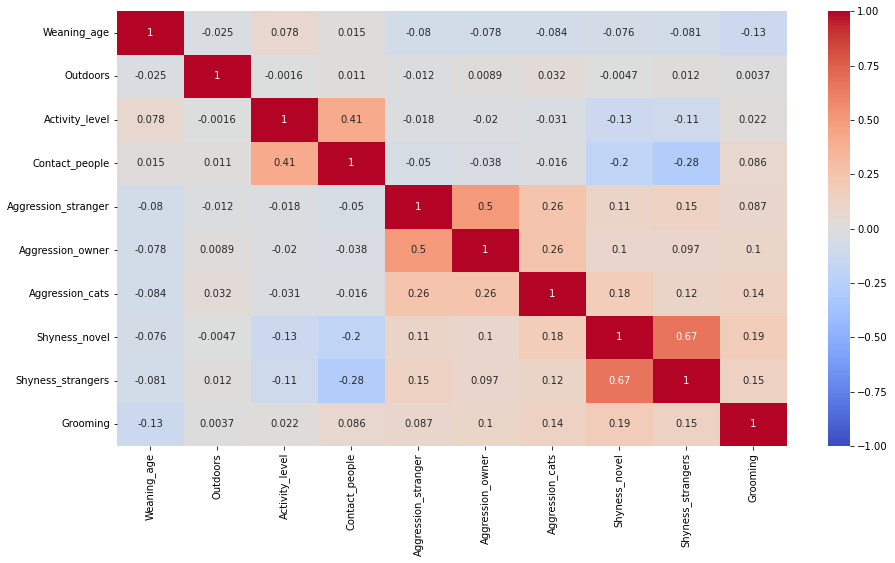

In [16]:
# Kendall's Tau for Correlation Between Ordinal Variables
kendall_corr = ordinal_variables.corr(method='kendall')
plt.figure(figsize=(15, 8))
sns.heatmap(kendall_corr, annot=True, cmap='coolwarm', vmin=-1, vmax=1);

I figured the aggression with people (stranger or owner) would be correlated. Likewise for the two shyness features. I don't think I will need to do any feature selection/extraction here since I think the model that would work best for this dataset all handle multicollinearity quite well. If necessary, I think a simple average of the two people aggression features to create a new feature Aggression_people and dropping the parents could be a good solution. Likewise with the shyness features. 

Point biserial correlation is used when you have one continuous variable and one dichotomous variable. Biserial correlation is used when you have two continuous variables, but one of them is artificially dichotomized. As the latter condition is not accurate here I will be using the former metric. 

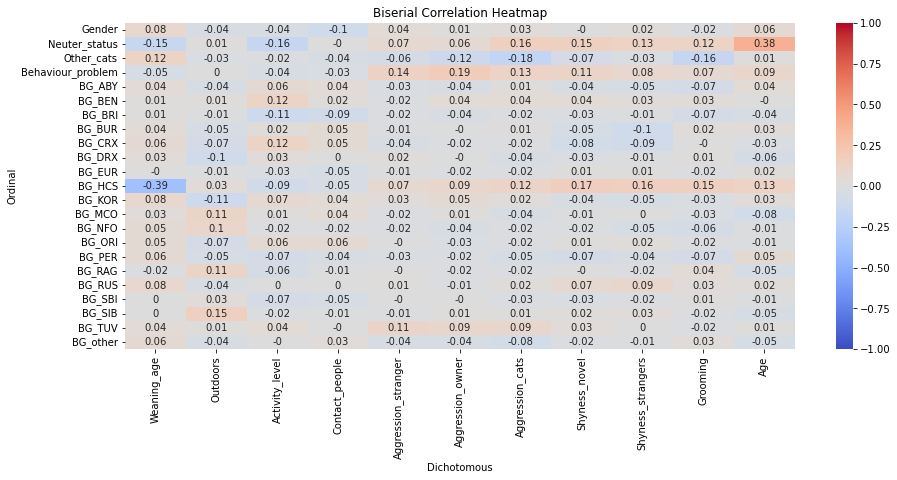

In [17]:
# Biserial Correlation Coefficient for dichXordinal if we treat ordinal_variables as continuous
biserial = pd.concat([dichotomous_variables, ordinal_variables, continuous_variable], axis=1)
correlation_matrix = pd.DataFrame(index=biserial.columns, columns=biserial.columns)
for i, column_i in enumerate(biserial.columns):
    for j, column_j in enumerate(biserial.columns):
        if i != j:
            corr, p_value = stats.pointbiserialr(biserial[column_i], biserial[column_j])
            correlation_matrix.at[column_i, column_j] = round(corr, 2)
heatmap_matrix = correlation_matrix.iloc[:23,23:] #drops anything not dich on "continuous"
plt.figure(figsize=(15, 6))
sns.heatmap(heatmap_matrix.astype(float), annot=True, cmap='coolwarm', vmin=-1, vmax=1)

# Add title and labels
plt.title('Biserial Correlation Heatmap')
plt.xlabel('Dichotomous')
plt.ylabel('Ordinal');

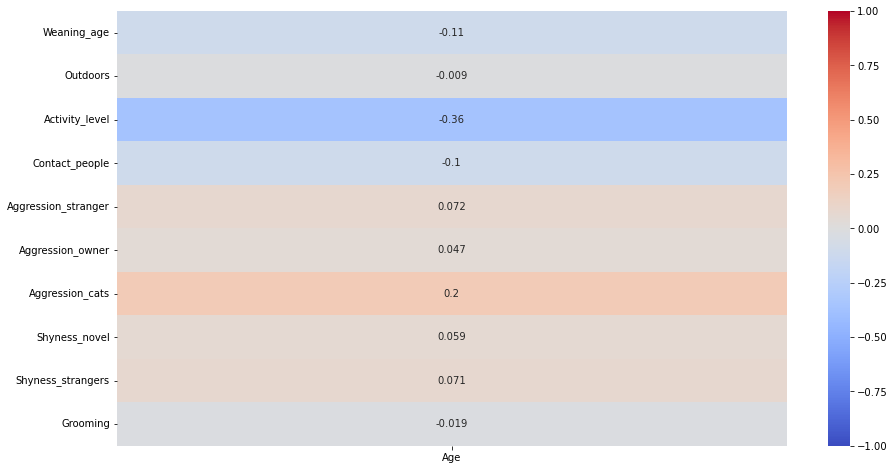

In [18]:
# Spearman's rho for contXordinal
spearman = pd.concat([continuous_variable, ordinal_variables], axis=1)

spearman_matrix = spearman.corr(method='spearman')

spearman_matrix = spearman_matrix.iloc[1:, [0]]

plt.figure(figsize=(15, 8))
sns.heatmap(spearman_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1);

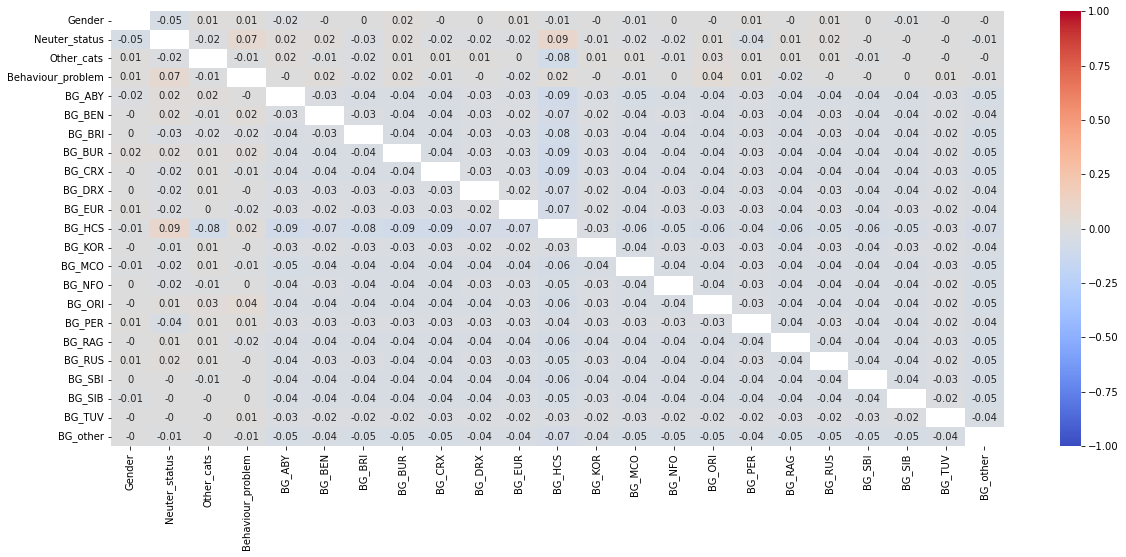

In [19]:
# phi coefficient for dichXdich
# Create an empty correlation matrix
dichotomous_columns = dichotomous_variables.columns
correlation_matrix = pd.DataFrame(index=dichotomous_columns, columns=dichotomous_columns)

# Calculate phi coefficient for each pair of columns
for i in range(len(dichotomous_columns)):
    for j in range(i+1, len(dichotomous_columns)):
        column1 = dichotomous_variables[dichotomous_columns[i]]
        column2 = dichotomous_variables[dichotomous_columns[j]]
        contingency_table = pd.crosstab(column1, column2)
        n = np.sum(contingency_table.values)
        n11 = contingency_table.iloc[1, 1]
        n10 = contingency_table.iloc[1, 0]
        n01 = contingency_table.iloc[0, 1]
        n00 = contingency_table.iloc[0, 0]
        phi = round((n11 * n00 - n10 * n01) / np.sqrt((n10 + n11) * (n00 + n01) * (n10 + n01) * (n00 + n11)),2)
        correlation_matrix.loc[dichotomous_columns[i], dichotomous_columns[j]] = phi
        correlation_matrix.loc[dichotomous_columns[j], dichotomous_columns[i]] = phi

# Convert the correlation matrix values to numeric type
correlation_matrix = correlation_matrix.astype(float)

# Plot the correlation matrix as a heatmap
plt.figure(figsize=(20, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1);

That's about as comprehensive and into the weeds as I'm willing to get. It looks like the only real concerns are those shyness traits and the aggression (towards people) traits. The models I'm going to be using are typically resistant to multicollinearity, and they don't seem to be *very* strongly correlated, but I want my coefficients to be interpretable, so I am going to go ahead and replace those four columns with their two aggregate counterparts. 

## Addressing Multicollinearity

In [20]:
# making agg columns for training set 
X_train['agg_shy'] = (X_train['Shyness_novel'] + X_train['Shyness_strangers']) / 2
X_train['agg_aggress_people'] = (X_train['Aggression_owner'] + X_train['Aggression_stranger']) / 2 
X_train.drop(columns=['Shyness_novel', 'Shyness_strangers', 'Aggression_stranger', 'Aggression_owner'], inplace=True)
X_train.columns

Index(['BG_ABY', 'BG_BEN', 'BG_BRI', 'BG_BUR', 'BG_CRX', 'BG_DRX', 'BG_EUR',
       'BG_HCS', 'BG_KOR', 'BG_MCO', 'BG_NFO', 'BG_ORI', 'BG_PER', 'BG_RAG',
       'BG_RUS', 'BG_SBI', 'BG_SIB', 'BG_TUV', 'BG_other', 'Age', 'Gender',
       'Neuter_status', 'Weaning_age', 'Outdoors', 'Other_cats',
       'Activity_level', 'Contact_people', 'Aggression_cats', 'Grooming',
       'Behaviour_problem', 'agg_shy', 'agg_aggress_people'],
      dtype='object')

In [21]:
# making agg columns for testing set
X_test['agg_shy'] = (X_test['Shyness_novel'] + X_test['Shyness_strangers']) / 2
X_test['agg_aggress_people'] = (X_test['Aggression_owner'] + X_test['Aggression_stranger']) / 2
X_test.drop(columns=['Shyness_novel', 'Shyness_strangers', 'Aggression_stranger', 'Aggression_owner'], inplace=True)
X_test.columns

Index(['BG_ABY', 'BG_BEN', 'BG_BRI', 'BG_BUR', 'BG_CRX', 'BG_DRX', 'BG_EUR',
       'BG_HCS', 'BG_KOR', 'BG_MCO', 'BG_NFO', 'BG_ORI', 'BG_PER', 'BG_RAG',
       'BG_RUS', 'BG_SBI', 'BG_SIB', 'BG_TUV', 'BG_other', 'Age', 'Gender',
       'Neuter_status', 'Weaning_age', 'Outdoors', 'Other_cats',
       'Activity_level', 'Contact_people', 'Aggression_cats', 'Grooming',
       'Behaviour_problem', 'agg_shy', 'agg_aggress_people'],
      dtype='object')

<div style="background-color: blue; padding: 10px; color: white;">
<h1>6. Modelling</h1>
<p> Random Forest. XGBoost. Multinomial Logistic Regression. </p>
</div>


## 6.1 Random Forest
Tried and true. Robust to multicollinearity. Can capture non-linear relationships. Can highlight feature importance. 
Not as interpretable (no coefficients in the same sense as there would be with linear . 

In [22]:
# How does the RandomForestClassifier() perform? I am also going to add class_weights=balanced as there is still plenty imbalance.
rf = RandomForestClassifier(class_weight='balanced')
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
add_to_master("Random Forest Multiclass (6)", y_test, y_pred, binary=False)

C:\Users\gwent\AppData\Local\Temp\ipykernel_24816\386060749.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  master_scores = master_scores.append(new_row, ignore_index=True)


,Model,Recall,F1,Precision,Accuracy
0,Random Forest Multiclass (6),0.17,0.14,0.29,0.68


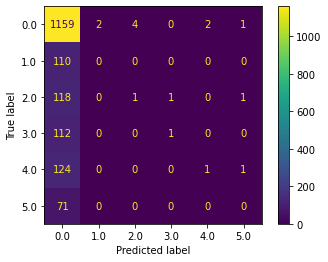

In [23]:
cm = confusion_matrix(y_test, y_pred, labels=rf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=rf.classes_)
disp.plot()
plt.show();

It's not doing super well, even with dropping compressing those couple of classes with few samples. Let's see how it does if I compress the categories further into 3 groups: **Not Suckers/0** (0's (never)), **Infrequent Suckers/1** (1's (1-3x/lifetime), 2's (1-12x/year), 3's (1-4x/month)), and **Frequent Suckers/2** (4's (1-3x/week), 5's (daily), 6's (many times/day), and  7's (most of the day)). I think this will stil capture the variance that is relevant to the problem at hand: is this cat I'm looking to adopt going to do this thing I find really cute?  
* 0 : 0
* 1: 1, 2, 3
* 2: 4, 5, 6, 7

## 6.2 Compressing Even Further to Mitigate Class-Imbalance-Related Performance 

In [24]:
# remember: the 6's and 7's are already in 5 at this point, and 1 is already in group 1!
y_train.replace([2, 3, 4, 5], [1, 1, 2, 2], inplace=True)
y_train.value_counts()

y_test.replace([2, 3, 4, 5], [1, 1, 2, 2], inplace=True)
y_test.value_counts()

0.0    1168
1.0     344
2.0     197
Name: ws_compressed, dtype: int64

C:\Users\gwent\AppData\Local\Temp\ipykernel_24816\386060749.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  master_scores = master_scores.append(new_row, ignore_index=True)


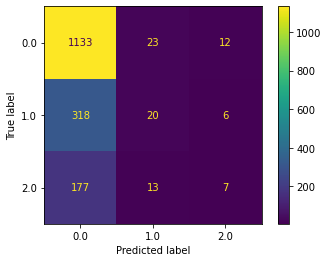

In [25]:
# trying RF default on newly compressed y
rf = RandomForestClassifier(class_weight='balanced')
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
add_to_master("Random Forest Multiclass (3)", y_test, y_pred, binary=False)

# confusion matrix, so we can get a more detailed view of its performance 
cm = confusion_matrix(y_test, y_pred, labels=rf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=rf.classes_)
disp.plot()
plt.show();

In [26]:
master_scores.head()

,Model,Recall,F1,Precision,Accuracy
0,Random Forest Multiclass (6),0.17,0.14,0.29,0.68
1,Random Forest Multiclass (3),0.35,0.32,0.44,0.68


## 6.3 Incorporating Resampling Methods to Address Class Imbalance

Still not doing too hot (but certainly better!). The model is still just predicting the majority class for most cases. I think it's time for a little resampling. I'm going to try random under sampling and random over sampling.  

In [27]:
rus = RandomUnderSampler()
X_resampled_rus, y_resampled_rus = rus.fit_resample(X_train, y_train)

ros = RandomOverSampler()
X_resampled_ros, y_resampled_ros = ros.fit_resample(X_train, y_train)

C:\Users\gwent\AppData\Local\Temp\ipykernel_24816\386060749.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  master_scores = master_scores.append(new_row, ignore_index=True)


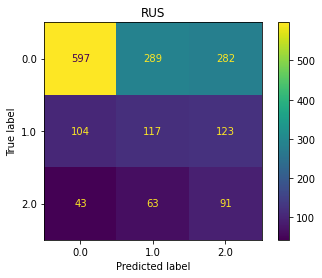

C:\Users\gwent\AppData\Local\Temp\ipykernel_24816\386060749.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  master_scores = master_scores.append(new_row, ignore_index=True)


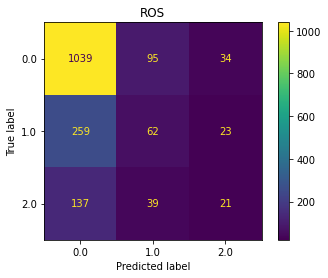

In [28]:
# no class_weights='balanced' here as it is redundant
rf= RandomForestClassifier(random_state=42)
rf.fit(X_resampled_rus, y_resampled_rus)
y_pred = rf.predict(X_test)
add_to_master("RUS Random Forest (3)", y_test, y_pred, binary=False)

cm = confusion_matrix(y_test, y_pred, labels=rf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=rf.classes_)
disp.plot()
plt.title("RUS")
plt.show()

rf= RandomForestClassifier(random_state=42)
rf.fit(X_resampled_ros, y_resampled_ros)
y_pred = rf.predict(X_test)
add_to_master("ROS Random Forest (3)", y_test, y_pred, binary=False)

cm = confusion_matrix(y_test, y_pred, labels=rf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=rf.classes_)
disp.plot()
plt.title("ROS")
plt.show()

In [29]:
master_scores.sort_values('Recall', ascending=False).head()

,Model,Recall,F1,Precision,Accuracy
2,RUS Random Forest (3),0.44,0.39,0.41,0.47
3,ROS Random Forest (3),0.39,0.39,0.44,0.66
1,Random Forest Multiclass (3),0.35,0.32,0.44,0.68
0,Random Forest Multiclass (6),0.17,0.14,0.29,0.68


I would say recall is the most important metric for our purposes as it highlights the suckers. I'm not super pleased with how the RUS model had quite a few false positives for the 0's. I want to try these resampling methods on the two other algorithms.

## 6.4 Multinomial Logistic Regression with Regularization 
The regularization should address that pesk multicollinearity if it's an issue. Logistic regression's coefficients are typically pretty interpretable, but only if the underlying relationship is linear. However, regularization worsens the interpretability since Lasso will shrink some feature's coefficients to 0 (which is how it handles multicollinearity) and Ridge does not drive them to zero, but still distributes its penalty across correlated features evenly which results in less meaningful variability. 

### 6.4.1 Lasso RUS

In [30]:
# MULTINOMIAL LOGISTIC REGRESSION - RUS LASSO
# scaling because we are applying regularization 
scaler = MinMaxScaler(feature_range=(0,5))

scaler.fit(X_train)
X_train_scaled = scaler.transform(X_resampled_rus)
X_test_scaled = scaler.transform(X_test)

# Instantiate model, multinomial can only handle saga solver when penalty=l1
logs = LogisticRegression(multi_class='multinomial', penalty='l1', solver='saga').fit(X_train_scaled, y_resampled_rus)

# Calculate Prediction
y_pred = logs.predict(X_test_scaled)

C:\Users\gwent\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


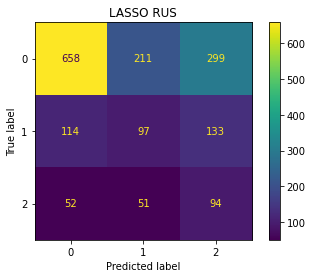

In [31]:
cms = confusion_matrix(y_test, y_pred)
disps = ConfusionMatrixDisplay(confusion_matrix=cms)
disps.plot()
plt.title('LASSO RUS')
plt.show()

In [32]:
# add_to_master(model_description, binary=True, y_true, y_predicted, df)
add_to_master('Lasso RUS', y_test, y_pred, binary=False)

master_scores.sort_values('Recall', ascending=False).head()

C:\Users\gwent\AppData\Local\Temp\ipykernel_24816\386060749.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  master_scores = master_scores.append(new_row, ignore_index=True)


,Model,Recall,F1,Precision,Accuracy
2,RUS Random Forest (3),0.44,0.39,0.41,0.47
4,Lasso RUS,0.44,0.4,0.42,0.5
3,ROS Random Forest (3),0.39,0.39,0.44,0.66
1,Random Forest Multiclass (3),0.35,0.32,0.44,0.68
0,Random Forest Multiclass (6),0.17,0.14,0.29,0.68


### 6.4.2 Lasso ROS

In [42]:
# MULTINOMIAL LOGISTIC REGRESSION - ROS LASSO
# scaling because we are applying regularization 
scaler = MinMaxScaler(feature_range=(0,5))

scaler.fit(X_train)
X_train_scaled = scaler.transform(X_resampled_ros)
X_test_scaled = scaler.transform(X_test)

# Instantiate model, multinomial can only handle saga solver when penalty=l1
log_lasso_ros = LogisticRegression(multi_class='multinomial', penalty='l1', solver='saga').fit(X_train_scaled, y_resampled_ros)

# Calculate Prediction
y_pred = logs.predict(X_test_scaled)

In [34]:
# add_to_master(model_description, binary=True, y_true, y_predicted, df)
add_to_master('LASSO ROS', y_test, y_pred, binary=False)

master_scores.sort_values('Recall', ascending=False).head()

C:\Users\gwent\AppData\Local\Temp\ipykernel_24816\386060749.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  master_scores = master_scores.append(new_row, ignore_index=True)


,Model,Recall,F1,Precision,Accuracy
2,RUS Random Forest (3),0.44,0.39,0.41,0.47
4,Lasso RUS,0.44,0.4,0.42,0.5
5,Lasso ROS,0.43,0.39,0.41,0.49
3,ROS Random Forest (3),0.39,0.39,0.44,0.66
1,Random Forest Multiclass (3),0.35,0.32,0.44,0.68


### 6.4.3 Ridge RUS

In [35]:
# MULTINOMIAL LOGISTIC REGRESSION - RUS RIDGE
# scaling because we are applying regularization 
scaler = MinMaxScaler(feature_range=(0,5))

scaler.fit(X_train)
X_train_scaled = scaler.transform(X_resampled_rus)
X_test_scaled = scaler.transform(X_test)

# Instantiate model, multinomial can only handle saga solver when penalty=l1
logs = LogisticRegression(multi_class='multinomial', penalty='l2', solver='lbfgs', max_iter=200).fit(X_train_scaled, y_resampled_rus)

# Calculate Prediction
y_pred = logs.predict(X_test_scaled)

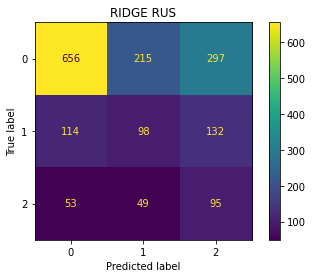

In [36]:
cms = confusion_matrix(y_test, y_pred)
disps = ConfusionMatrixDisplay(confusion_matrix=cms)
disps.plot()
plt.title('RIDGE RUS')
plt.show()

In [37]:
# add_to_master(model_description, binary=True, y_true, y_predicted, df)
add_to_master('RIDGE RUS', y_test, y_pred, binary=False)

master_scores.sort_values('Recall', ascending=False).head()

C:\Users\gwent\AppData\Local\Temp\ipykernel_24816\386060749.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  master_scores = master_scores.append(new_row, ignore_index=True)


,Model,Recall,F1,Precision,Accuracy
2,RUS Random Forest (3),0.44,0.39,0.41,0.47
4,Lasso RUS,0.44,0.4,0.42,0.5
6,RIDGE RUS,0.44,0.4,0.42,0.5
5,Lasso ROS,0.43,0.39,0.41,0.49
3,ROS Random Forest (3),0.39,0.39,0.44,0.66


### 6.4.1 Ridge ROS

In [38]:
# ROS RIDGE
# scaling because we are applying regularization 
scaler = MinMaxScaler(feature_range=(0,5))

scaler.fit(X_train)
X_train_scaled = scaler.transform(X_resampled_ros)
X_test_scaled = scaler.transform(X_test)

# Instantiate model, multinomial can only handle saga solver when penalty=l1
logs = LogisticRegression(multi_class='multinomial', penalty='l2', solver='lbfgs', max_iter=200).fit(X_train_scaled, y_resampled_ros)

# Calculate Prediction
y_pred = logs.predict(X_test_scaled)

C:\Users\gwent\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [39]:
# add_to_master(model_description, binary=True, y_true, y_predicted, df)
add_to_master('RIDGE ROS', y_test, y_pred, binary=False)

master_scores.sort_values('Recall', ascending=False).head()

C:\Users\gwent\AppData\Local\Temp\ipykernel_24816\386060749.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  master_scores = master_scores.append(new_row, ignore_index=True)


,Model,Recall,F1,Precision,Accuracy
2,RUS Random Forest (3),0.44,0.39,0.41,0.47
4,Lasso RUS,0.44,0.4,0.42,0.5
6,RIDGE RUS,0.44,0.4,0.42,0.5
5,Lasso ROS,0.43,0.39,0.41,0.49
7,Ridge Multinomial Logistic Regression ROS,0.43,0.39,0.41,0.49


Certainly some improvement. Starting to see some higher recall scores without having to sacrific accuracy as much. Still not doing *well*, though. 

## 6.4 Gradient Boost
I'm expecting this to be the top performer. Great with multicollinearity, class imbalance, nonlinear relationships, and can highlight feature importance. Still suffers from a lack of absolute interpretabliity like other ensemble methods. 

C:\Users\gwent\AppData\Local\Temp\ipykernel_24816\386060749.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  master_scores = master_scores.append(new_row, ignore_index=True)


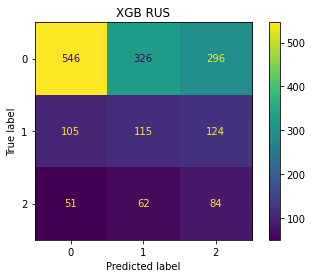

C:\Users\gwent\AppData\Local\Temp\ipykernel_24816\386060749.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  master_scores = master_scores.append(new_row, ignore_index=True)


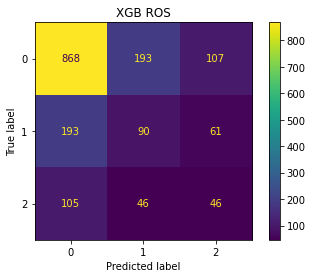

In [40]:
# RUS
xgb_clf = xgb.XGBClassifier()
xgb_clf.fit(X_resampled_rus, y_resampled_rus)
y_pred = xgb_clf.predict(X_test)
add_to_master('XGB RUS', y_test, y_pred, binary=False)

cms = confusion_matrix(y_test, y_pred)
disps = ConfusionMatrixDisplay(confusion_matrix=cms)
disps.plot()
plt.title('XGB RUS')
plt.show()

# ROS
xgb_clf = xgb.XGBClassifier()
xgb_clf.fit(X_resampled_ros, y_resampled_ros)
y_pred = xgb_clf.predict(X_test)
add_to_master('XGB ROS', y_test, y_pred, binary=False)

cms = confusion_matrix(y_test, y_pred)
disps = ConfusionMatrixDisplay(confusion_matrix=cms)
disps.plot()
plt.title('XGB ROS')
plt.show()

In [43]:
master_scores.sort_values(['Recall', 'Accuracy'], ascending=False)

,Model,Recall,F1,Precision,Accuracy
4,Lasso RUS,0.44,0.4,0.42,0.5
6,RIDGE RUS,0.44,0.4,0.42,0.5
2,RUS Random Forest (3),0.44,0.39,0.41,0.47
5,Lasso ROS,0.43,0.39,0.41,0.49
7,Ridge Multinomial Logistic Regression ROS,0.43,0.39,0.41,0.49
9,XGB ROS,0.41,0.41,0.41,0.59
8,XGB RUS,0.41,0.37,0.39,0.44
3,ROS Random Forest (3),0.39,0.39,0.44,0.66
1,Random Forest Multiclass (3),0.35,0.32,0.44,0.68
0,Random Forest Multiclass (6),0.17,0.14,0.29,0.68


## 6.5 Tuning Hyperparameter on Best-Performing Model Thus Far

Surprisingly, Lasso Regularized Multinomial Logistic Regression trained on Randomly Under-Sampled majority classes has won! The only issue is, I don't think I can really tune it that much more. I guess I'll see if changing C has any effect. Ridge If not, I will try to tune the XGB ROS model as it has the next highest recall/accuracy pair. 

In [44]:
# MULTINOMIAL LOGISTIC REGRESSION - ROS LASSO
# scaling because we are applying regularization 
scaler = MinMaxScaler(feature_range=(0,5))

scaler.fit(X_train)
X_train_scaled = scaler.transform(X_resampled_ros)
X_test_scaled = scaler.transform(X_test)

# Instantiate model, multinomial can only handle saga solver when penalty=l1
log_lasso_ros = LogisticRegression(multi_class='multinomial', penalty='l1', solver='saga').fit(X_train_scaled, y_resampled_ros)

# Calculate Prediction
y_pred = logs.predict(X_test_scaled)

LogisticRegression(multi_class='multinomial', penalty='l1', solver='saga')

In [56]:
param_grid = {'C': [0.01, 0.1, 1, 10, 100]}
grid_search = GridSearchCV(log_lasso_ros, param_grid, cv=5, scoring='recall_macro')

grid_search.fit(X_train_scaled, y_resampled_ros)
results = pd.DataFrame(grid_search.cv_results_)
results.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.106919,0.006101,0.001397,0.000477,0.01,{'C': 0.01},0.471110,0.480436,0.468181,0.467024,0.489877,0.475326,0.008667,5
1,0.161176,0.027609,0.001188,0.000403,0.1,{'C': 0.1},0.479695,0.482895,0.490847,0.462106,0.474546,0.478018,0.009554,4
2,0.430473,0.022143,0.001536,0.000524,1,{'C': 1},0.482758,0.485349,0.487175,0.464554,0.476990,0.479365,0.008165,1
3,0.440055,0.007861,0.000966,0.000003,10,{'C': 10},0.482758,0.485349,0.487176,0.464554,0.476377,0.479243,0.008204,2
4,0.428678,0.001713,0.001172,0.000396,100,{'C': 100},0.482758,0.484124,0.487176,0.464554,0.476377,0.478998,0.008035,3


They were all fairly close in score, but C=0.01 has the lowest fit time, which isn't super important for our present problem, especially as we're talking fractions of a second here. But for best practices and sake of efficiency, I'm going to roll the dice with C=0.01.

In [58]:
lass_ros_tuned = LogisticRegression(multi_class='multinomial', 
                                    penalty='l1', solver='saga', C=0.01).fit(X_train_scaled, y_resampled_ros)
lass_ros_tuned.fit(X_train_scaled, y_resampled_ros)
y_pred = lass_ros_tuned.predict(X_test_scaled)
add_to_master('Lasso ROS Tuned', y_test, y_pred, binary=False)
master_scores.sort_values(['Recall', 'Accuracy'], ascending=False)

,Model,Recall,F1,Precision,Accuracy
10,Tuned Lasso ROS,0.44,0.4,0.41,0.52
11,Tuned Lasso ROS,0.44,0.4,0.41,0.52
13,Lasso ROS Tuned,0.44,0.4,0.41,0.52
14,Lasso ROS Tuned,0.44,0.4,0.41,0.52
4,Lasso RUS,0.44,0.4,0.42,0.5
6,RIDGE RUS,0.44,0.4,0.42,0.5
2,RUS Random Forest (3),0.44,0.39,0.41,0.47
5,Lasso ROS,0.43,0.39,0.41,0.49
7,Ridge Multinomial Logistic Regression ROS,0.43,0.39,0.41,0.49
12,Tuned Lasso ROS,0.43,0.39,0.41,0.49


## 6.6 Choose a Model!

Well the tuned model certainly did better, even if marginally so. So I'm going to choose that one. 

In [59]:
lass_ros_tuned

LogisticRegression(C=0.01, multi_class='multinomial', penalty='l1',
                   solver='saga')

<div style="background-color: blue; padding: 10px; color: white;">
<h1>7. Digging Deeper into Performance for Chosen Model </h1>
<p> I want to know where specifically it made misclassifications, especially in pairing the original scores back up with the compressed ones. I assume most of the mistakes are in the 6 and 7 categories. </p>
</div>

### Question: When you reassociate the original class pre-binarization, which ones is it getting wrong most often?

In [1]:
test_pred = pd.DataFrame({'True': y_test, 'Predicted': y_pred})

NameError: name 'pd' is not defined

In [ ]:
test_pred

In [ ]:
# reassociate original variable
final = test_pred.join(df_multi['Wool_sucking'])
final

In [ ]:
# should be 626
mismatched = final[final['Predicted'] != final['True']]
mismatched

In [ ]:
should_be_0 = mismatched[mismatched['True'] == 0]
should_be_1 = mismatched[mismatched['True'] == 1]

In [ ]:
should_be_0['Wool_sucking'].value_counts()

In [ ]:
should_be_1['Wool_sucking'].value_counts()

In [ ]:
mismatched['Wool_sucking'].value_counts()

<div style="background-color: blue; padding: 10px; color: white;">
<h1>8. Conclusion</h1>
<p> What's the final model? Why?</p>
</div>

In [ ]:
master_scores.sort_values('Recall', ascending=False)